Рассматривается задача обучения без учителя (кластеризация) и применение к ней различных методов	
- +2 Применен метод k средних
- +4 Применены иерархические методы
- +2 Подсчитаны метрики для задачи кластеризации
- +2 Визуализированы результаты кластеризации

информативные графики
доказать, что устойчиво
дбскан

rtol
док стринг
пофиксить двойной цикл
сравнение методов

## init

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler
import plotly.figure_factory as ff
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
import plotly.graph_objects as go
import warnings
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import StandardScaler
from typing import Literal
from sklearn.cluster import DBSCAN

In [2]:
warnings.filterwarnings("ignore")

SEED = 42

metric = "sil"
k_values = list(range(2, 11))
# k_values = [3]

In [3]:
data = pd.read_csv("../data/health_lifestyle_dataset.csv")

## classes

In [4]:
class MyKMeans:
    """
    Кластеризация K-средних

    args:
    - n_clusters: int - количество кластеров
    - max_iter: int - максимальное количество итераций
    - tol: float - минимальное значение для выхода из цикла
    - rtol: float - максимальное значение для выхода из цикла

    return:
    cluster_centers_ - центры кластеров
    labels_ - список лэйблов
    inertia_ - получившаяся инерция
    """

    def __init__(
        self,
        n_clusters=3,
        max_iter=300,
        tol=1e-4,
        rtol=1e4,
        random_state=None,
    ):
        self.n_clusters = int(n_clusters)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.rtol = float(rtol)
        self.random_state = np.random.RandomState(random_state)

        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _distance_sq(self, X, centers):
        # (x - c)^2 = x^2 + c^2 - 2 x·c
        X_sq = np.sum(X**2, axis=1)[:, None]
        C_sq = np.sum(centers**2, axis=1)[None, :]
        XC = X.dot(centers.T)
        return X_sq + C_sq - 2 * XC

    def _init_random(self, X):
        n_samples = X.shape[0]
        idx = self.random_state.choice(
            n_samples,
            self.n_clusters,
            replace=False,
        )

        return X[idx].copy()

    def _assign_labels(self, X, centers):
        dist_sq = self._distance_sq(X, centers)
        return np.argmin(dist_sq, axis=1), np.min(dist_sq, axis=1)

    def _compute_centers(self, X, labels):
        n_features = X.shape[1]
        centers = np.zeros((self.n_clusters, n_features), dtype=X.dtype)
        for k in range(self.n_clusters):
            members = X[labels == k]
            if len(members) == 0:
                centers[k] = X[
                    self.random_state.randint(0, X.shape[0])
                ]  # почему тут не ломается устойчивость алгоритма
            else:
                centers[k] = members.mean(axis=0)
        return centers

    def _run(self, X):
        centers = self._init_random(X)

        for i in range(1, self.max_iter + 1):
            labels, dist_sq = self._assign_labels(X, centers)
            inertia = dist_sq.sum()
            new_centers = self._compute_centers(X, labels)
            center_shift = np.sqrt(
                np.sum((centers - new_centers) ** 2, axis=1)
            ).max()
            # center_shift = self._distance_sq(centers, new_centers)
            centers = new_centers
            if center_shift <= self.tol or center_shift >= self.rtol:
                return centers, labels, inertia

        return centers, labels, inertia

    def fit(self, X):
        X = np.asarray(X, dtype=float)

        (
            self.cluster_centers_,
            self.labels_,
            self.inertia_,
        ) = self._run(X)

        return self

## data

In [5]:
data

,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,Male,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,Female,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,Male,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,Female,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,Female,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,53,Male,33.1,4726,3.9,2.0,3118,0,1,56,105,76,282,0,0
99996,99997,22,Male,35.1,11554,4.5,3.1,1967,0,0,51,149,77,192,0,0
99997,99998,37,Male,18.9,3924,3.8,1.0,2328,0,0,69,92,117,218,0,0
99998,99999,72,Female,27.8,16110,5.6,0.8,3093,0,0,93,164,72,188,0,0


In [6]:
data.isnull().sum()

id                   0
age                  0
gender               0
bmi                  0
daily_steps          0
sleep_hours          0
water_intake_l       0
calories_consumed    0
smoker               0
alcohol              0
resting_hr           0
systolic_bp          0
diastolic_bp         0
cholesterol          0
family_history       0
disease_risk         0
dtype: int64

In [7]:
data = data.sample(n=1000, random_state=SEED)

In [8]:
df = data.copy()
X_pre = df[["sleep_hours", "water_intake_l"]].values

## kmeans

In [9]:
results = []
models = {}

In [10]:
for k in k_values:
    km = KMeans(n_clusters=k, random_state=SEED)
    km.fit(X_pre)
    labels = km.labels_

    sil = silhouette_score(X_pre, labels)
    cal = calinski_harabasz_score(X_pre, labels)
    dav = davies_bouldin_score(X_pre, labels)

    results.append(
        {
            "k": k,
            "wcss": km.inertia_,
            "sil": sil,
            "cal": cal,
            "dav": dav,
        }
    )
    models[k] = km

In [11]:
scores_df = pd.DataFrame(results)
display(scores_df)

,k,wcss,sil,cal,dav
0,2,2678.596115,0.452401,1164.174511,0.865943
1,3,1976.712984,0.406213,964.888454,0.908638
2,4,1395.586111,0.386119,1048.389288,0.966072
3,5,1095.500760,0.389681,1068.810425,0.814596
4,6,986.466636,0.355728,970.575833,0.869587
5,7,748.734928,0.375561,1117.241558,0.829649
6,8,672.842286,0.365578,1080.424394,0.855696
7,9,589.697798,0.354318,1095.042457,0.866763
8,10,538.636171,0.348034,1074.997150,0.898215


In [12]:
best_k_index = scores_df[metric].idxmax()

best_k_value = scores_df.loc[best_k_index, "k"]

scores_df[metric].max(), best_k_value

(np.float64(0.4524009977784975), np.int64(2))

In [13]:
best_model = models[best_k_value]
labels = best_model.labels_

df_with_cluster = df.copy()
df_with_cluster["cluster"] = labels

print(df_with_cluster["cluster"].value_counts().sort_index())

cluster
0    510
1    490
Name: count, dtype: int64


In [14]:
centers = best_model.cluster_centers_

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=X_pre[:, 0],
        y=X_pre[:, 1],
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="Viridis",
            size=8,
            opacity=0.8,
            showscale=False,
        ),
        name="Data Points",
        text=[f"Cluster: {label}" for label in labels],
        hovertemplate="X: %{x}<br>Y: %{y}<br>%{text}<extra></extra>",
    )
)

fig.add_trace(
    go.Scatter(
        x=centers[:, 0],
        y=centers[:, 1],
        mode="markers",
        marker=dict(
            symbol="x",
            size=15,
            color="black",
            line=dict(width=2, color="white"),
        ),
        name="Cluster Centers",
        hovertemplate="Center X: %{x}<br>Center Y: %{y}<extra></extra>",
    )
)

fig.update_layout(
    title=f"K-Means Clustering (k={best_k_value})",
    xaxis_title="Feature 1",
    yaxis_title="Feature 2",
    width=500,
    height=300,
    showlegend=True,
)

fig.show()

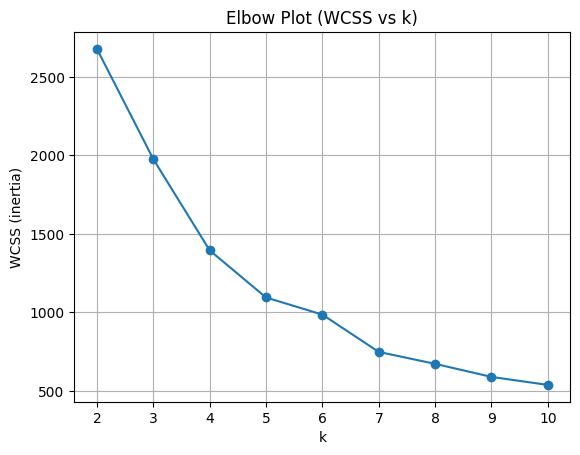

In [16]:
plt.figure()
plt.plot(scores_df["k"], scores_df["wcss"], marker="o")
plt.title("Elbow Plot (WCSS vs k)")
plt.xlabel("k")
plt.ylabel("WCSS (inertia)")
plt.grid(True)
plt.show()

In [17]:
my_results = []
my_models = {}

In [18]:
for k in k_values:
    km = MyKMeans(n_clusters=k, random_state=SEED)
    km.fit(X_pre)
    labels = km.labels_

    sil = silhouette_score(X_pre, labels)
    cal = calinski_harabasz_score(X_pre, labels)
    dav = davies_bouldin_score(X_pre, labels)

    my_results.append(
        {
            "k": k,
            "wcss": km.inertia_,
            "sil": sil,
            "cal": cal,
            "dav": dav,
        }
    )
    my_models[k] = km

In [19]:
my_scores_df = pd.DataFrame(my_results)
display(my_scores_df)

,k,wcss,sil,cal,dav
0,2,2678.304391,0.452401,1164.174511,0.865943
1,3,2004.622263,0.398541,944.454872,0.933221
2,4,1598.436391,0.354670,873.210372,0.846829
3,5,1068.571183,0.399924,1102.014900,0.805704
4,6,850.851772,0.392728,1156.959348,0.758301
5,7,766.166742,0.369140,1087.914854,0.834551
6,8,678.173115,0.375626,1070.817685,0.828259
7,9,597.328529,0.370013,1079.471073,0.811283
8,10,531.543144,0.362818,1090.810009,0.845272


In [20]:
best_k_index = my_scores_df[metric].idxmax()

best_k_value = my_scores_df.loc[best_k_index, "k"]

my_scores_df[metric].max(), best_k_value

(np.float64(0.4524009977784975), np.int64(2))

In [21]:
best_model = models[best_k_value]
labels = best_model.labels_

df_with_cluster = df.copy()
df_with_cluster["cluster"] = labels

print(df_with_cluster["cluster"].value_counts().sort_index())

cluster
0    510
1    490
Name: count, dtype: int64


In [22]:
centers = best_model.cluster_centers_

In [23]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=X_pre[:, 0],
        y=X_pre[:, 1],
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="Viridis",
            size=8,
            opacity=0.8,
            showscale=False,
        ),
        name="Data Points",
        text=[f"Cluster: {label}" for label in labels],
        hovertemplate="X: %{x}<br>Y: %{y}<br>%{text}<extra></extra>",
    )
)

fig.add_trace(
    go.Scatter(
        x=centers[:, 0],
        y=centers[:, 1],
        mode="markers",
        marker=dict(
            symbol="x",
            size=15,
            color="black",
            line=dict(width=2, color="white"),
        ),
        name="Cluster Centers",
        hovertemplate="Center X: %{x}<br>Center Y: %{y}<extra></extra>",
    )
)

fig.update_layout(
    title=f"MyKMeans Clustering (k={best_k_value})",
    xaxis_title="Feature 1",
    yaxis_title="Feature 2",
    width=500,
    height=300,
    showlegend=True,
)

fig.show()

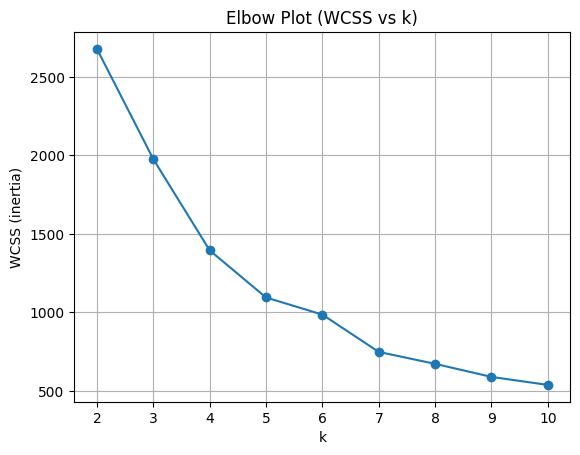

In [24]:
plt.figure()
plt.plot(my_scores_df["k"], scores_df["wcss"], marker="o")
plt.title("Elbow Plot (WCSS vs k)")
plt.xlabel("k")
plt.ylabel("WCSS (inertia)")
plt.grid(True)
plt.show()

## hierarchical

In [25]:
aglo_results = []
aglo_models = {}

In [26]:
for k in k_values:
    agc = AgglomerativeClustering(n_clusters=k)
    labels = agc.fit_predict(X_pre)

    sil = silhouette_score(X_pre, labels)
    cal = calinski_harabasz_score(X_pre, labels)
    dav = davies_bouldin_score(X_pre, labels)

    aglo_results.append(
        {
            "k": k,
            "wcss": km.inertia_,
            "sil": sil,
            "cal": cal,
            "dav": dav,
        }
    )
    aglo_models[k] = agc

In [27]:
aglo_scores_df = pd.DataFrame(aglo_results)
display(aglo_scores_df)

,k,wcss,sil,cal,dav
0,2,531.543144,0.426532,1033.712865,0.900751
1,3,531.543144,0.374883,871.181785,0.966502
2,4,531.543144,0.312943,821.081567,1.048037
3,5,531.543144,0.333402,890.917947,0.909200
4,6,531.543144,0.324588,924.521578,0.854778
5,7,531.543144,0.314681,902.317897,0.923595
6,8,531.543144,0.311540,899.553860,0.894236
7,9,531.543144,0.315460,902.382001,0.872159
8,10,531.543144,0.319198,930.247136,0.837108


In [28]:
best_k_index = aglo_scores_df[metric].idxmax()

best_k_value = aglo_scores_df.loc[best_k_index, "k"]

aglo_scores_df[metric].max(), best_k_value

(np.float64(0.4265317899909872), np.int64(2))

In [29]:
Z = linkage(X_pre, method="ward")

In [30]:
fig = ff.create_dendrogram(
    X_pre,
    linkagefun=lambda x: Z,
)
fig.update_layout(
    width=900,
    height=400,
)
fig.show()

In [31]:
labels = fcluster(Z, t=best_k_value, criterion="maxclust")
labels -= 1

In [32]:
groups = [X_pre[np.where(labels == i)] for i in range(best_k_value)]
centers = np.vstack([group.mean(axis=0) for group in groups])

In [33]:
df_with_cluster = df.copy()
df_with_cluster["cluster"] = labels

print(df_with_cluster["cluster"].value_counts().sort_index())

cluster
0    444
1    556
Name: count, dtype: int64


In [34]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=X_pre[:, 0],
        y=X_pre[:, 1],
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="Viridis",
            size=8,
            opacity=0.8,
            showscale=False,
        ),
        name="Data Points",
        text=[f"Cluster: {label}" for label in labels],
        hovertemplate="X: %{x}<br>Y: %{y}<br>%{text}<extra></extra>",
    )
)

fig.add_trace(
    go.Scatter(
        x=centers[:, 0],
        y=centers[:, 1],
        mode="markers",
        marker=dict(
            symbol="x",
            size=15,
            color="black",
            line=dict(width=2, color="white"),
        ),
        name="Cluster Centers",
        hovertemplate="Center X: %{x}<br>Center Y: %{y}<extra></extra>",
    )
)

fig.update_layout(
    title=f"Agglomerative Clustering (k={best_k_value})",
    xaxis_title="Feature 1",
    yaxis_title="Feature 2",
    width=500,
    height=300,
    showlegend=True,
)

fig.show()

## dbscan

Labels: [-1  0  1  2  3  4  5  6  7  8  9 10]


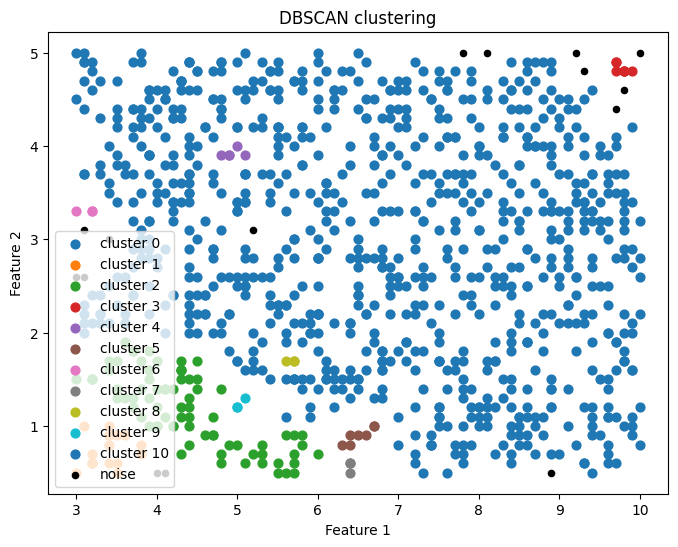

In [35]:
X_scaled = StandardScaler().fit_transform(X_pre)

db = DBSCAN(eps=0.15, min_samples=3).fit(X_scaled)

labels = db.labels_

print("Labels:", np.unique(labels))

plt.figure(figsize=(8, 6))

unique_labels = set(labels)

for lbl in unique_labels:
    mask = labels == lbl
    if lbl == -1:
        plt.scatter(
            X_pre[mask, 0],
            X_pre[mask, 1],
            c="black",
            s=20,
            label="noise",
        )
    else:
        plt.scatter(
            X_pre[mask, 0],
            X_pre[mask, 1],
            s=40,
            label=f"cluster {lbl}",
        )

plt.legend()
plt.title("DBSCAN clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## сравнение

In [36]:
k_means = scores_df[metric].max()
my_k_means = my_scores_df[metric].max()
aglo = aglo_scores_df[metric].max()

In [37]:
print("лучшая sil (k-средних): ", k_means)
print("лучшая sil (самописно k-средних): ", my_k_means)
print("лучшая sil (иерархический метод): ", aglo)

лучшая sil (k-средних):  0.4524009977784975
лучшая sil (самописно k-средних):  0.4524009977784975
лучшая sil (иерархический метод):  0.4265317899909872


In [38]:
print(
    "метод лучше: ",
    "самописно k-средних" if my_k_means > aglo else "иерархический метод",
    "\nразница: ",
    np.abs(my_k_means - aglo),
)

метод лучше:  самописно k-средних 
разница:  0.02586920778751034
